In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from PIL import Image

# Датасет

Для начала посмотрим на датасеты с _kaggle_, так как они дополнительно обработаны и ставят более узкую и простую задачу.

In [2]:
# Download dataset with Kaggle CLI (483 M).
# Reuired: installed Kaggle CLI and Kaggle API key.
# !kaggle competitions download -c covid-segmentation

## Medseg Images

In [3]:
def resize_dataset(d, size=(128, 128)):
    return np.array([np.array(Image.fromarray(image).resize(size))
                     for image in d])

In [4]:
im_medseg = np.load('raw-data-kaggle/images_medseg.npy')

In [5]:
im_medseg.shape  # -- 100 slices 512x512

(100, 512, 512, 1)

In [6]:
im_medseg = resize_dataset(im_medseg[:, :, :, 0])

In [7]:
im_medseg.shape

(100, 128, 128)

In [8]:
im_medseg[0, :5, :5]  # --  одно значение -- интенсивность черно-белого

array([[-1408.5106, -1408.5106, -1408.5106, -1408.5106, -1408.5106],
       [-1408.5106, -1408.5106, -1408.5106, -1408.5106, -1408.5106],
       [-1408.5106, -1408.5106, -1408.5106, -1408.5106, -1408.5106],
       [-1408.5106, -1408.5106, -1408.5106, -1408.5106, -1408.5106],
       [-1408.5106, -1408.5106, -1408.5106, -1408.5106, -1408.5106]],
      dtype=float32)

In [9]:
def show_im_row(images):
    n = images.shape[0]
    figure, axes = plt.subplots(1, n, figsize=(n * 15, 15))
    for ax, image in zip(axes, images):
        ax.imshow(image, cmap='Greys')

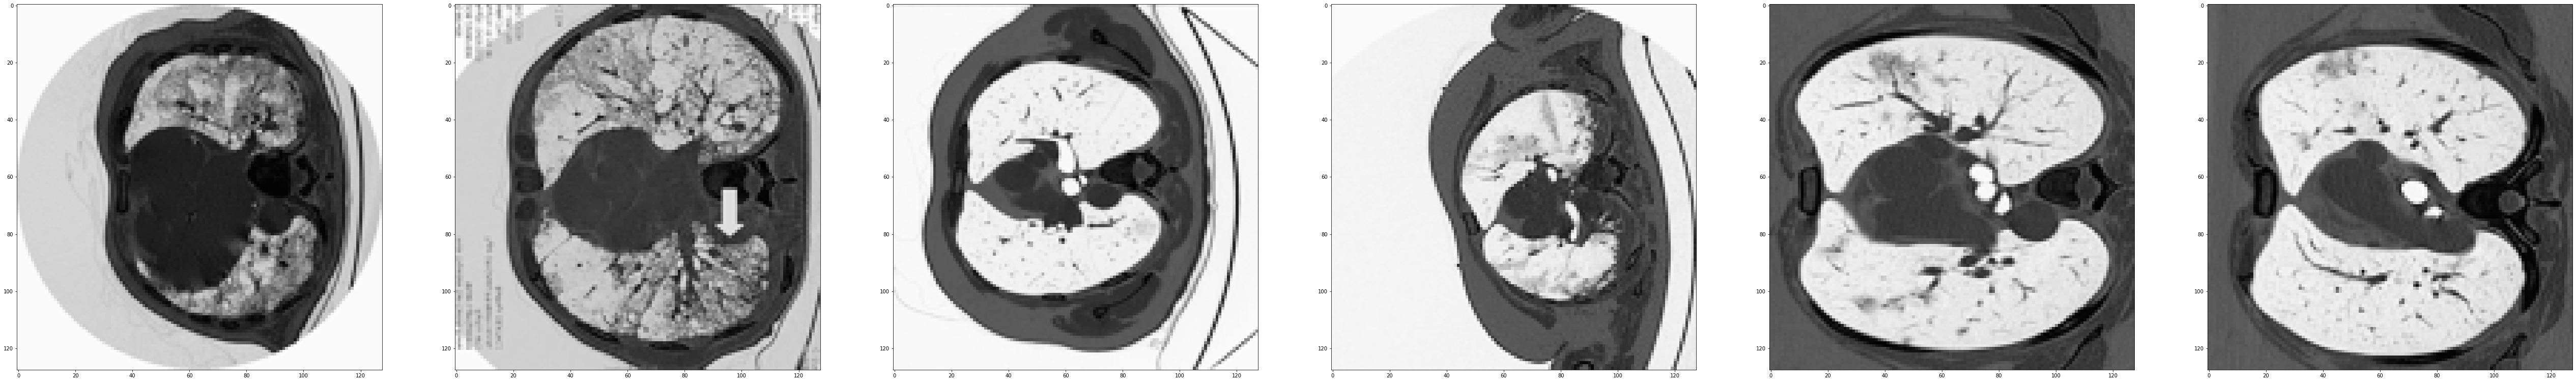

In [10]:
show_im_row(im_medseg[0:6])

Видим, что снимки довольно разнородные: с разным фоном, разной яркостью и контрастом. Модели придется искать закономерности между различными областями картинки, а не определенными цветами.

## Medseg masks

In [11]:
mk_medseg_big = np.load('raw-data-kaggle/masks_medseg.npy')

In [12]:
mk_medseg_big.shape  # 100 that same slices 512x512, but with 4 labels

(100, 512, 512, 4)

In [13]:
mk_medseg_big[0, 256, 256, :]  # if ith value is True, a pixel has label i

array([False, False, False,  True])

In [14]:
mk_medseg = np.zeros((4, 100, 128, 128))
for i in range(4):
    mk_medseg[i] = resize_dataset(mk_medseg_big[:, :, :, i])
    
del mk_medseg_big

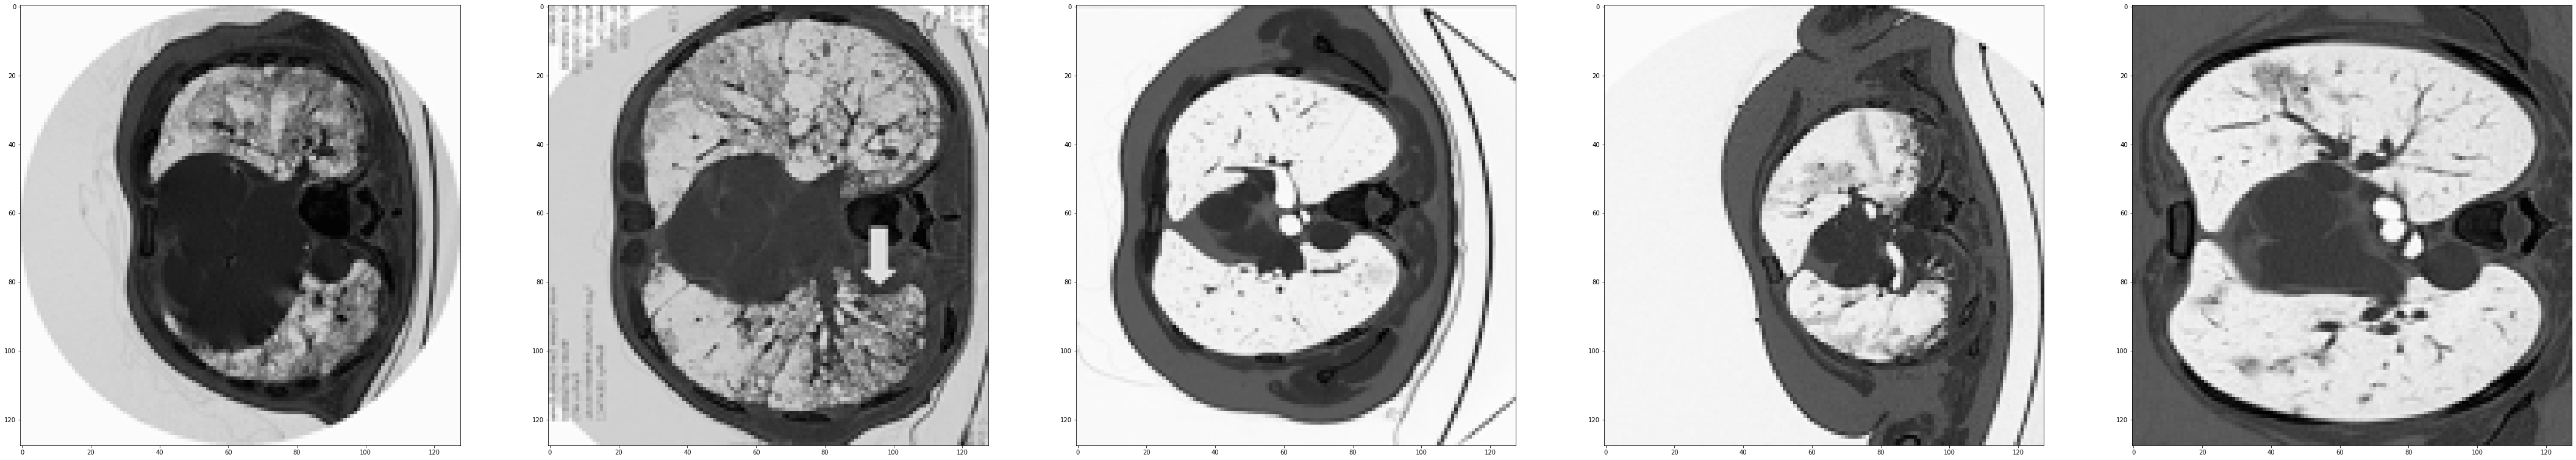

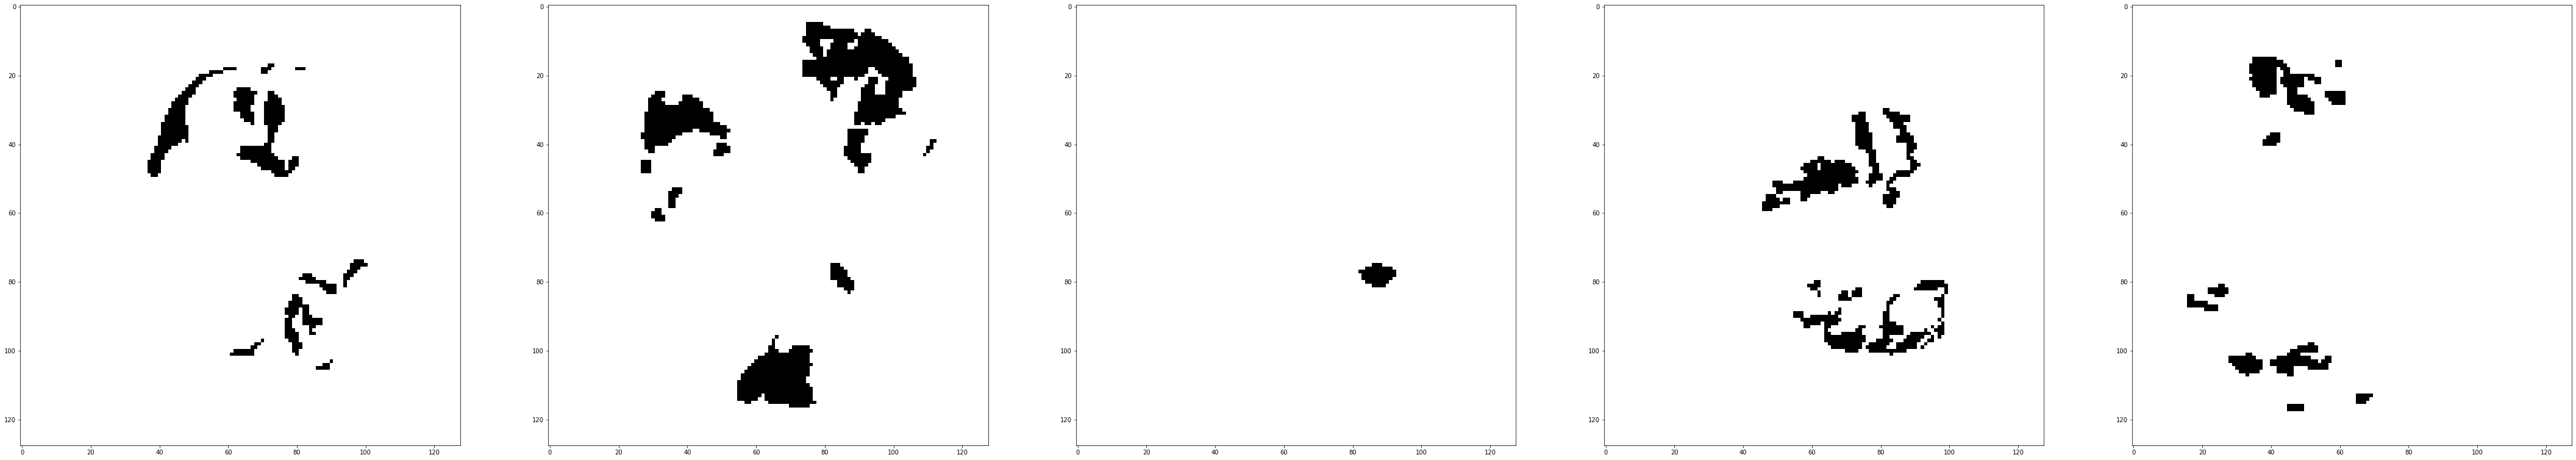

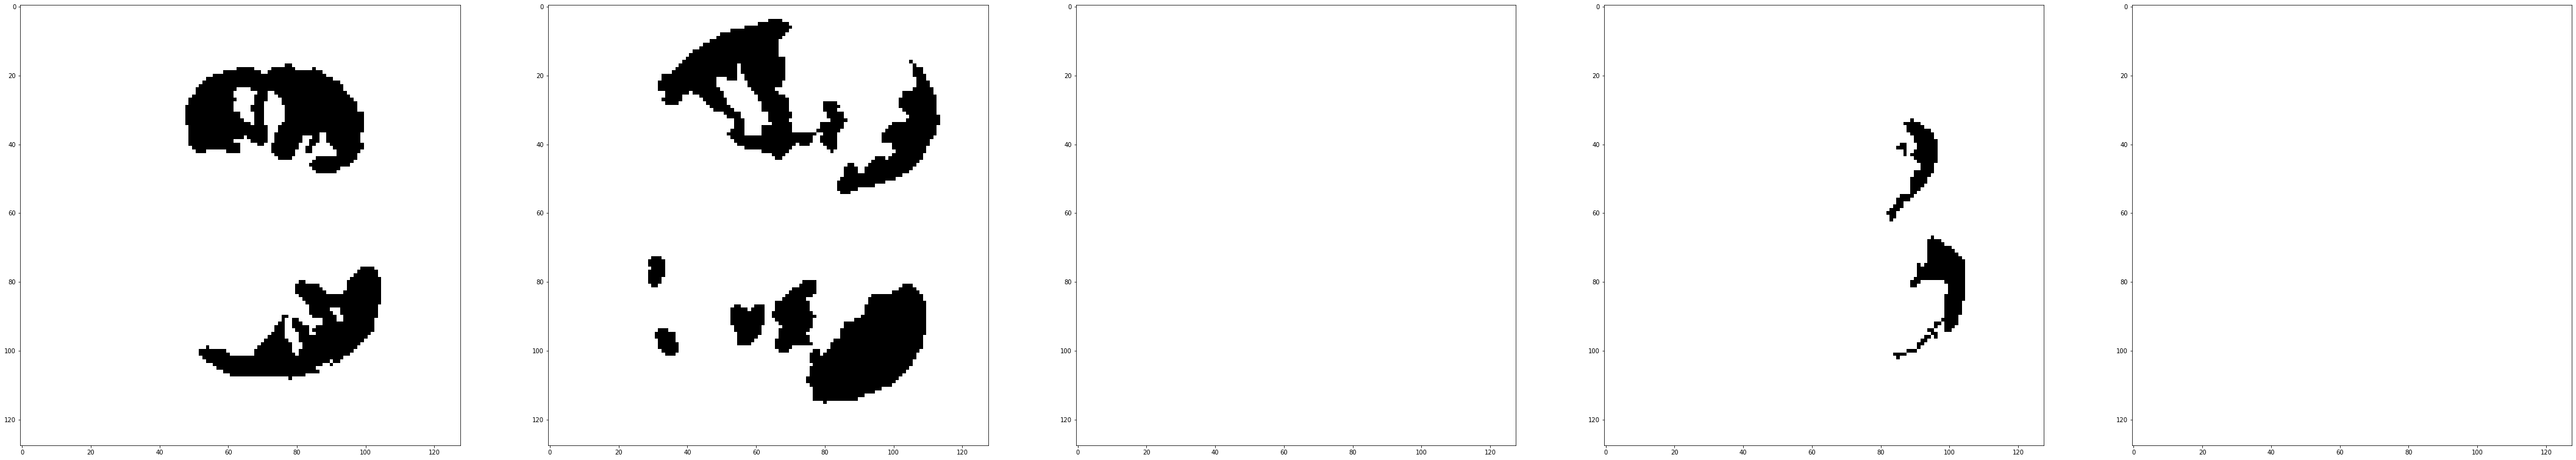

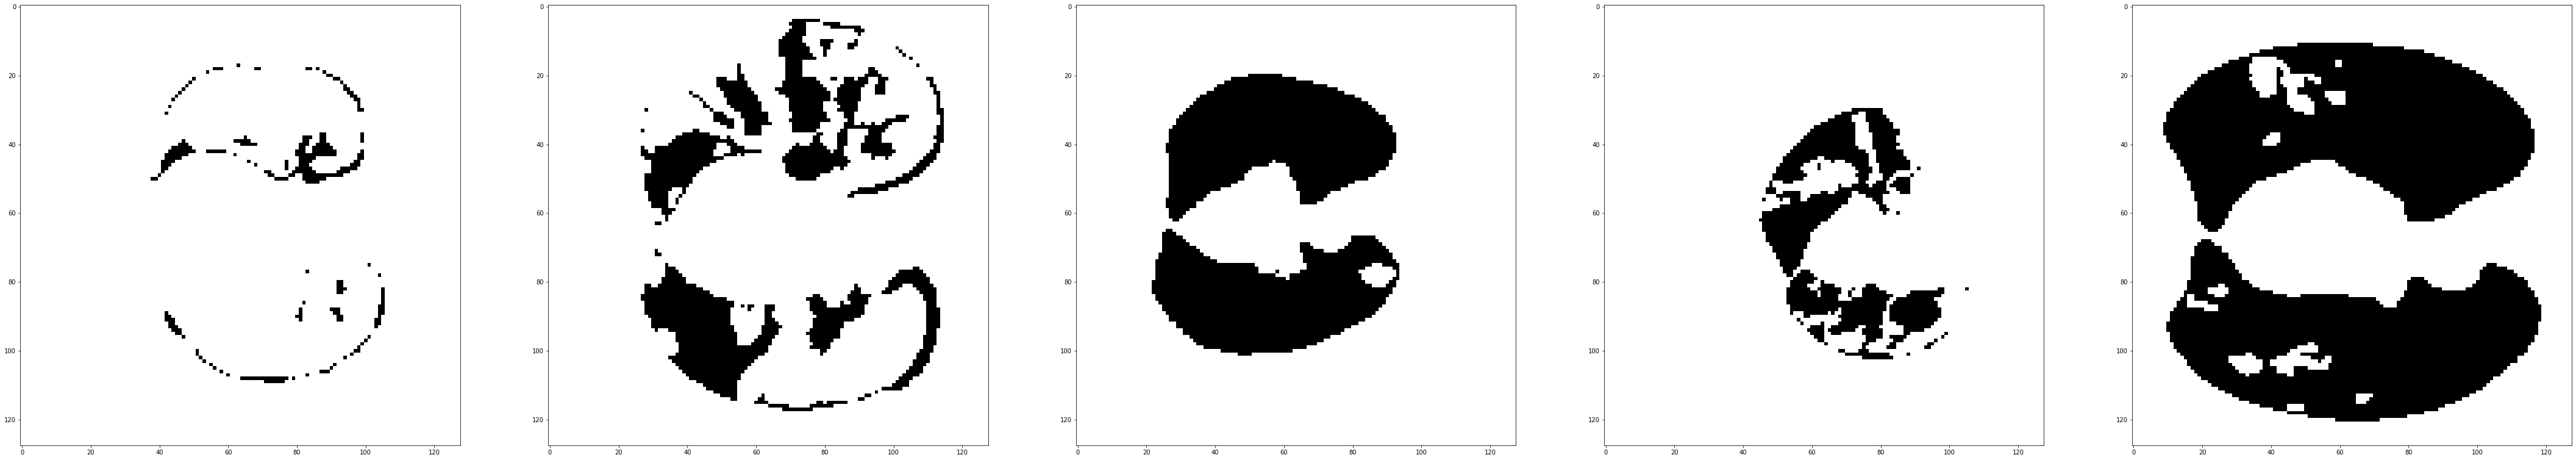

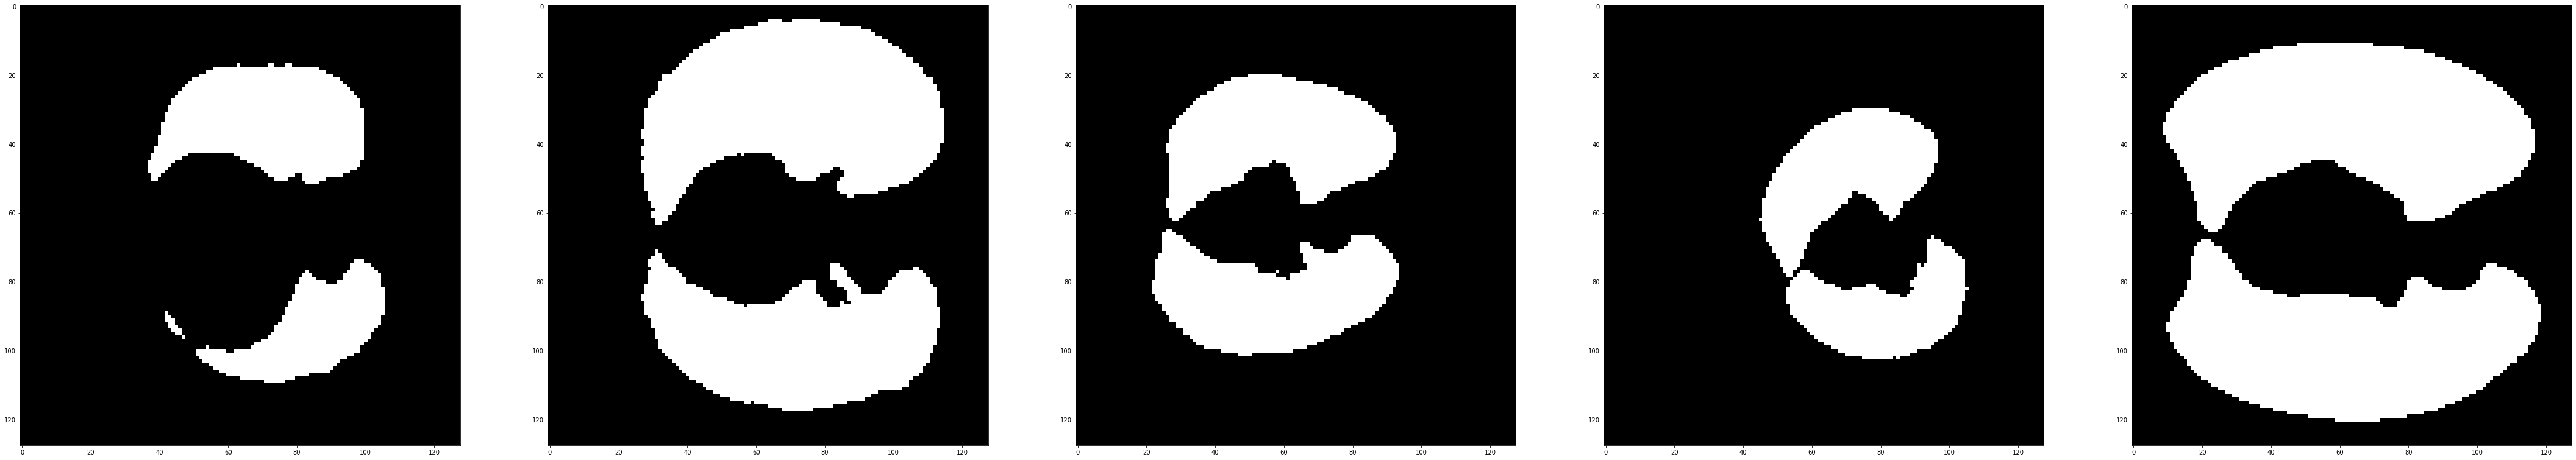

In [15]:
show_im_row(im_medseg[:5])
for i in range(4):
    show_im_row(mk_medseg[i, :5])

Имеем, что маски представляют собой массивы булов, которые для каждого пикселя определяют его соответствующую метку: 1 - матовое стекло, 2 - легочная консолидация, 3 - легкие (не 1 и 2), 4 - фон.

## Radiopedia

Можно предположить, что данные снимки будут выглядеть аналогично.

In [16]:
im_radio = np.load('raw-data-kaggle/images_radiopedia.npy')

In [17]:
im_radio.shape

(829, 512, 512, 1)

In [18]:
im_radio = resize_dataset(im_radio[:, :, :, 0])

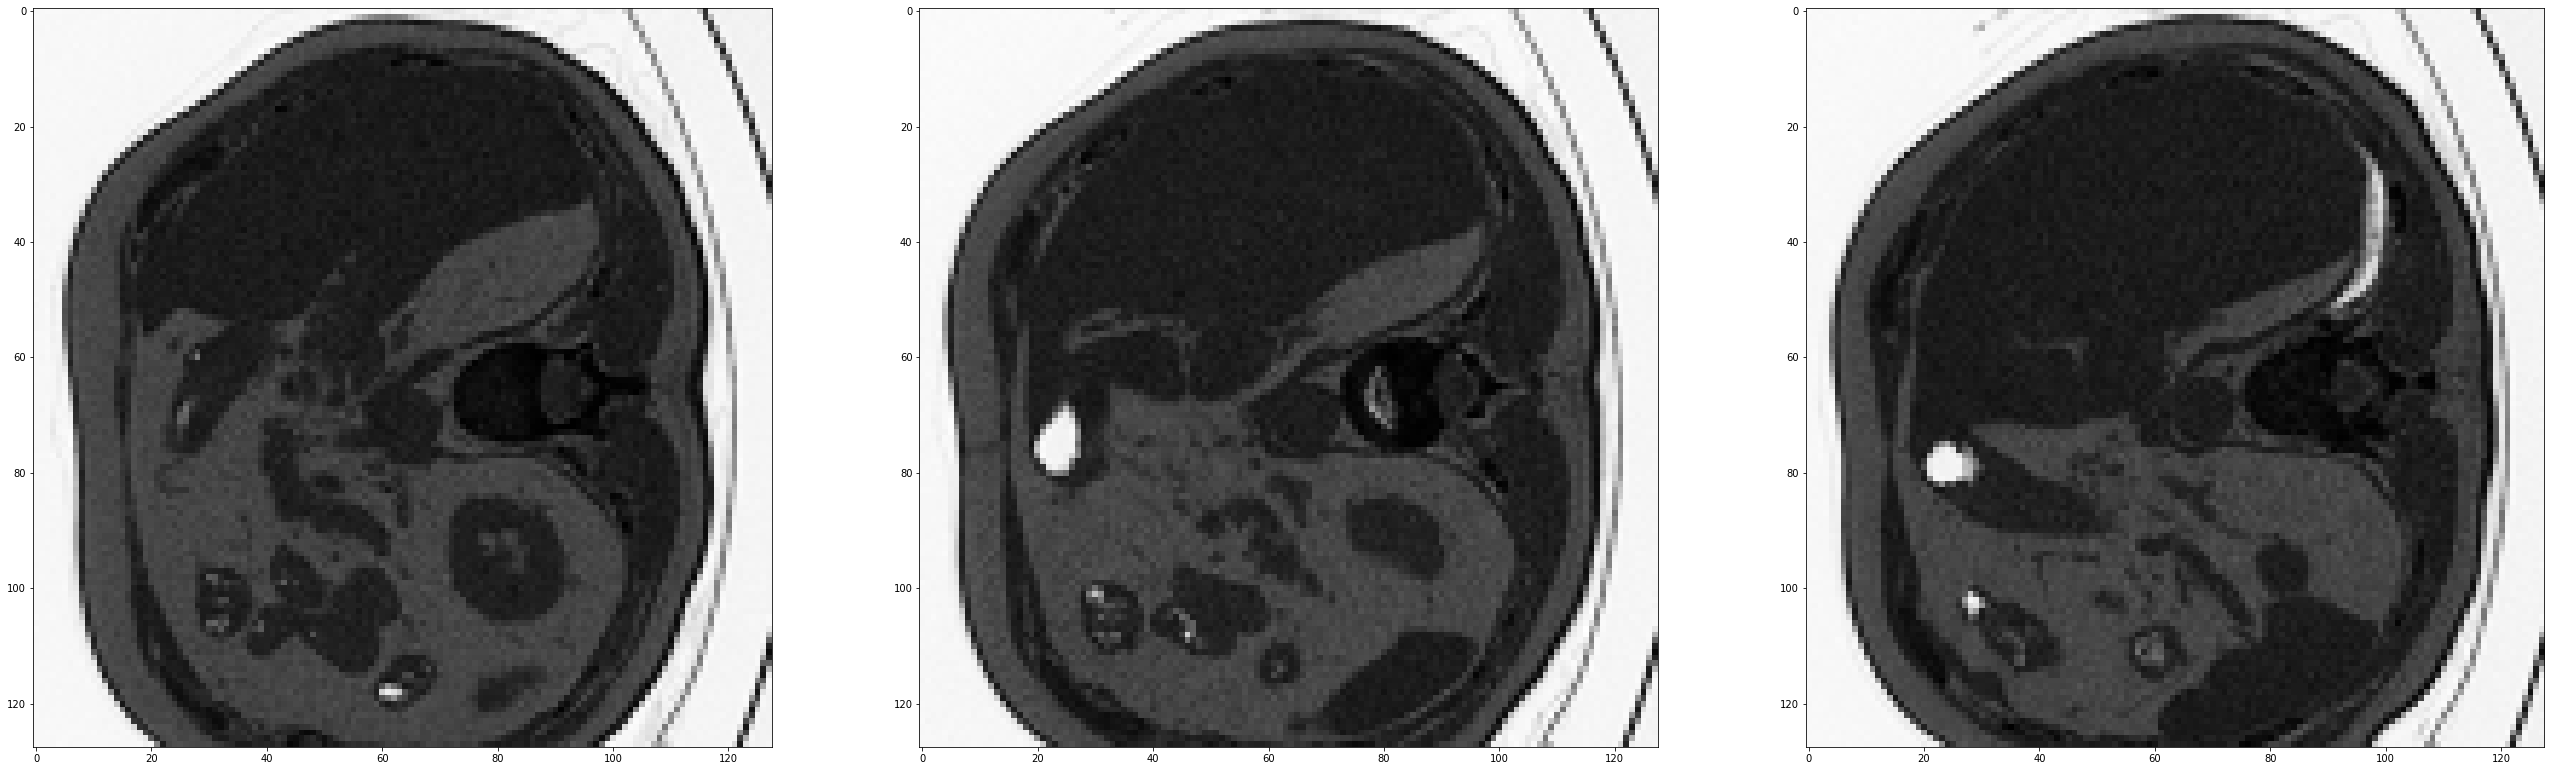

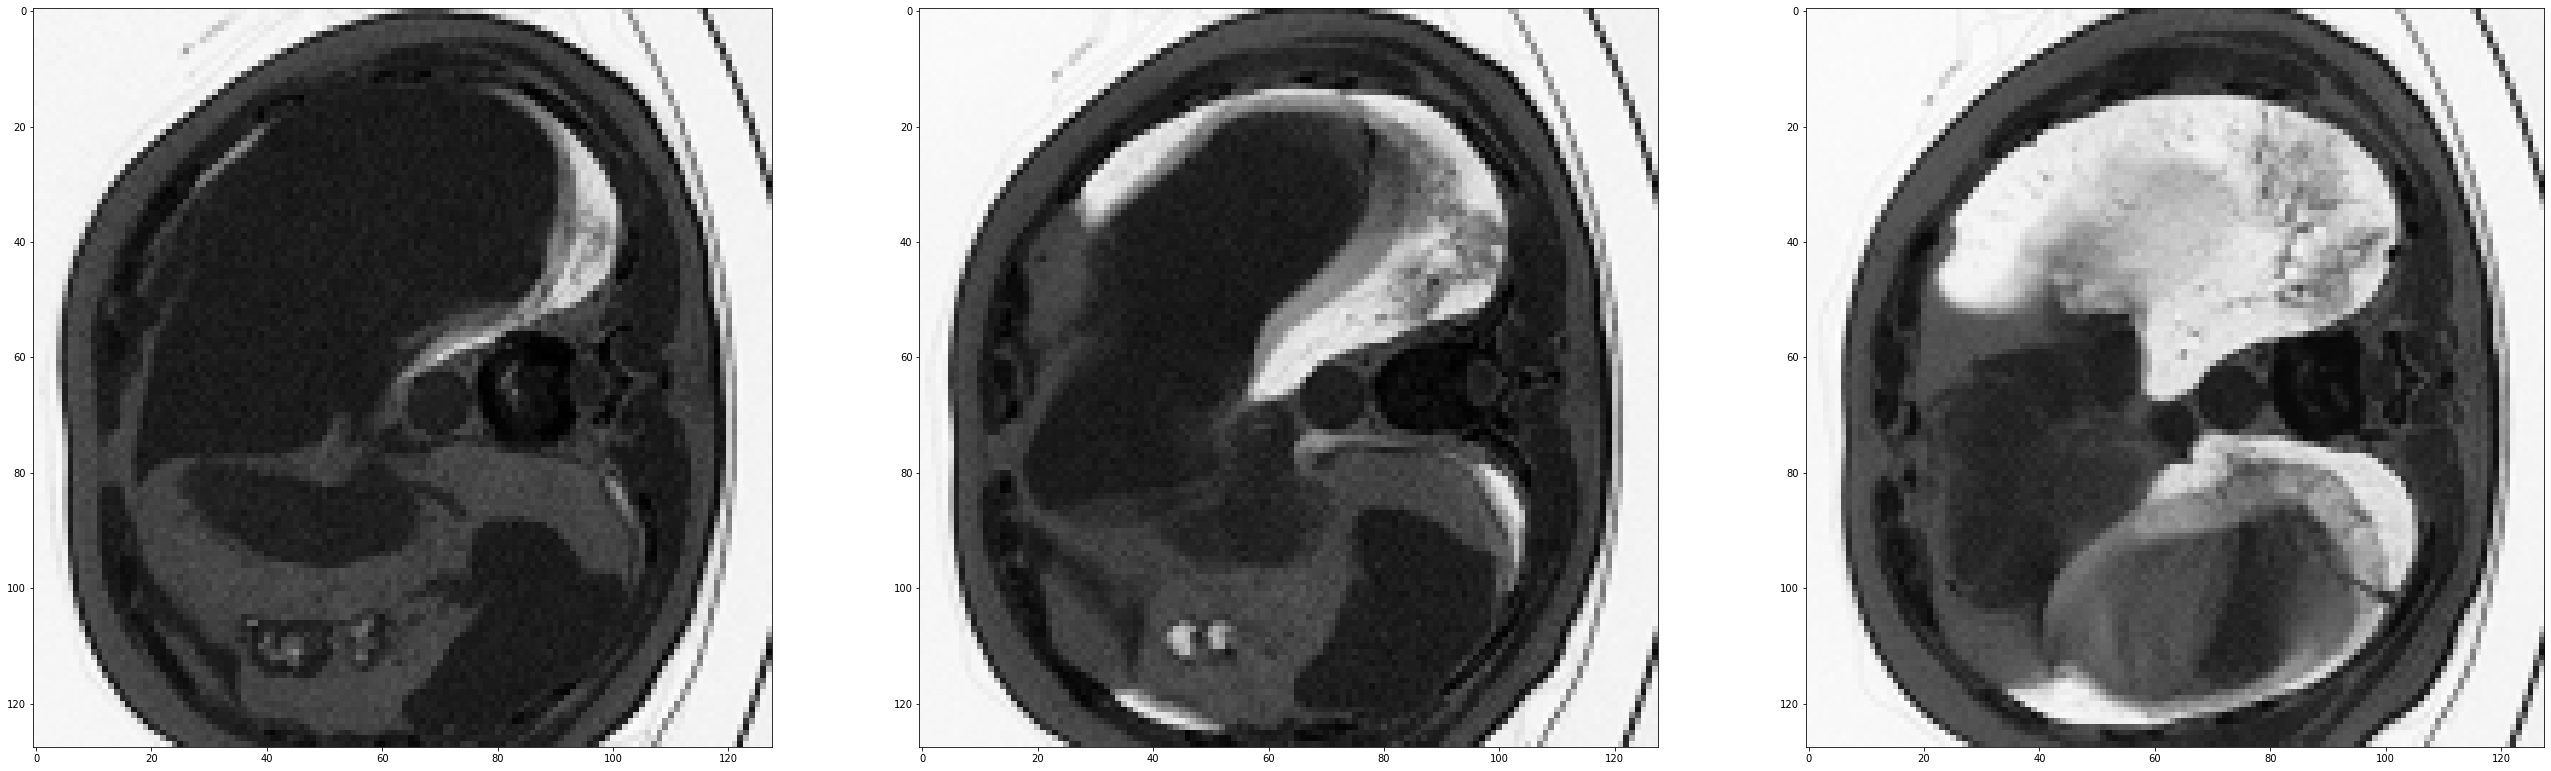

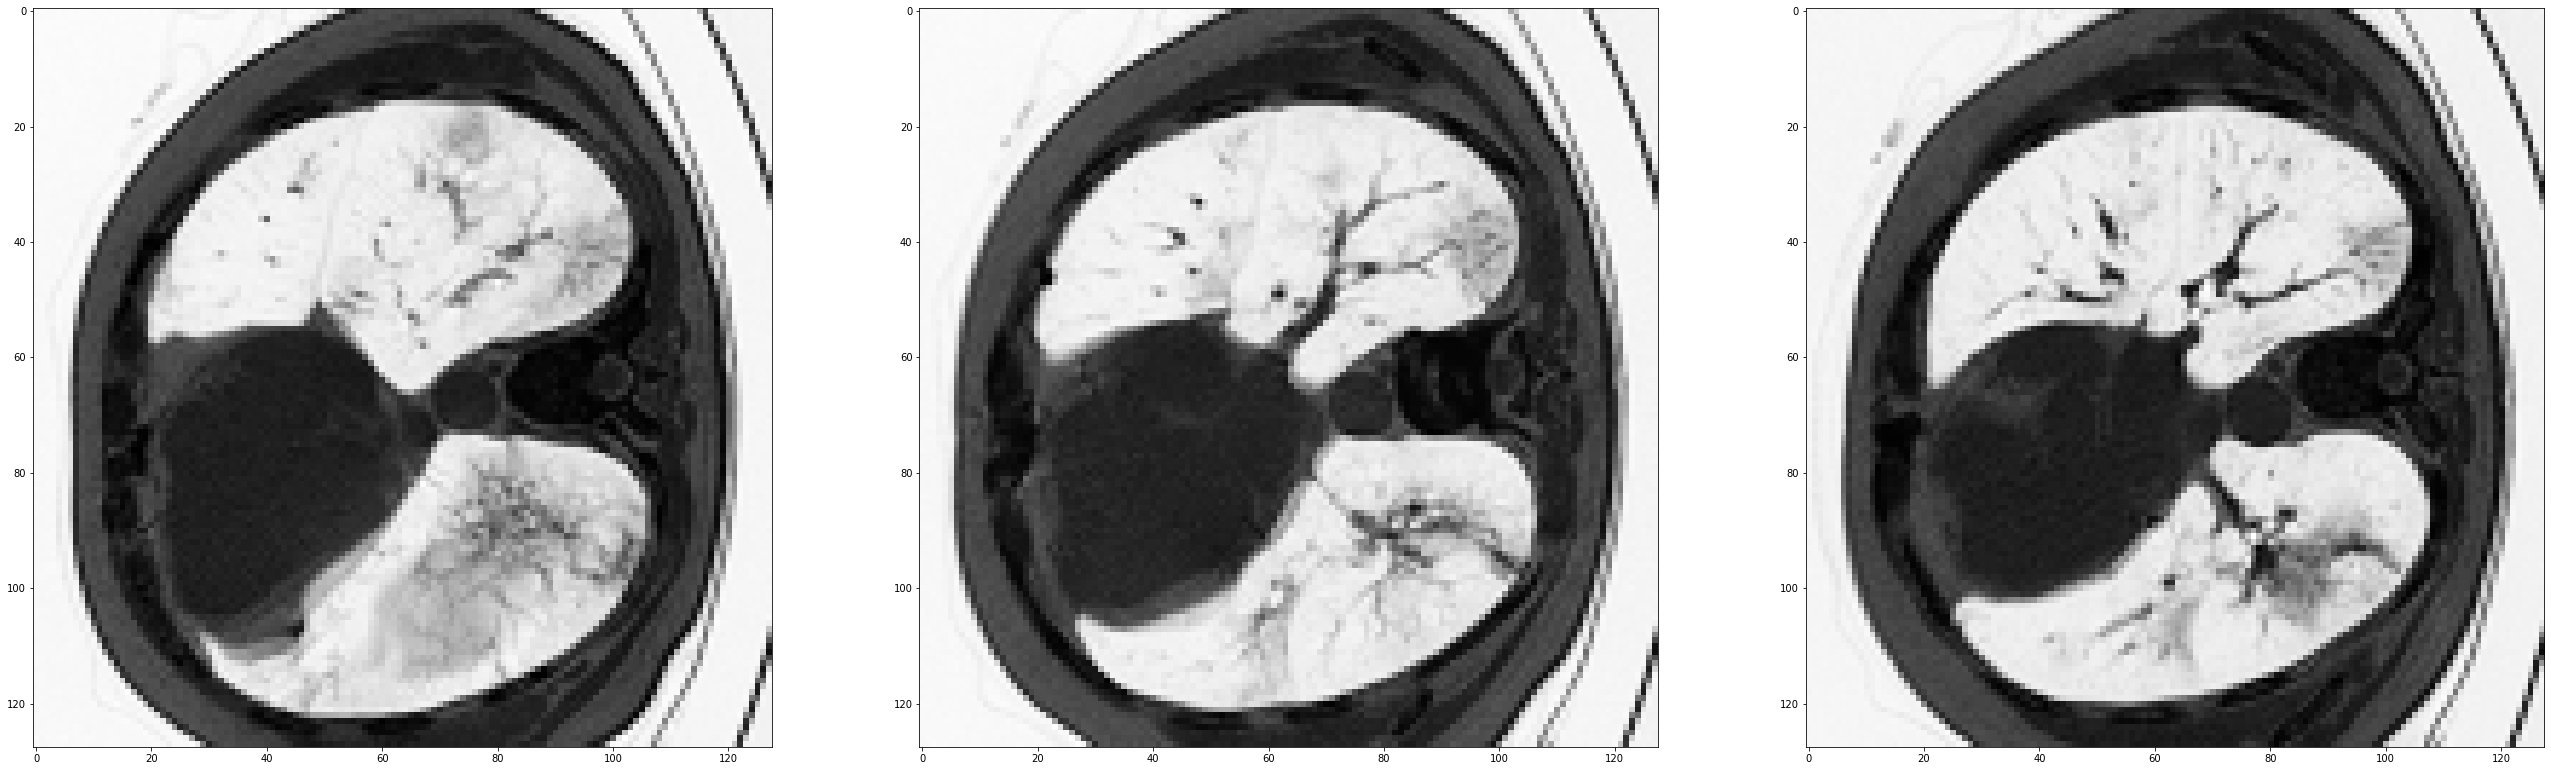

In [19]:
for i in range(0, 20, 9):
    show_im_row(im_radio[i:i+9:3])

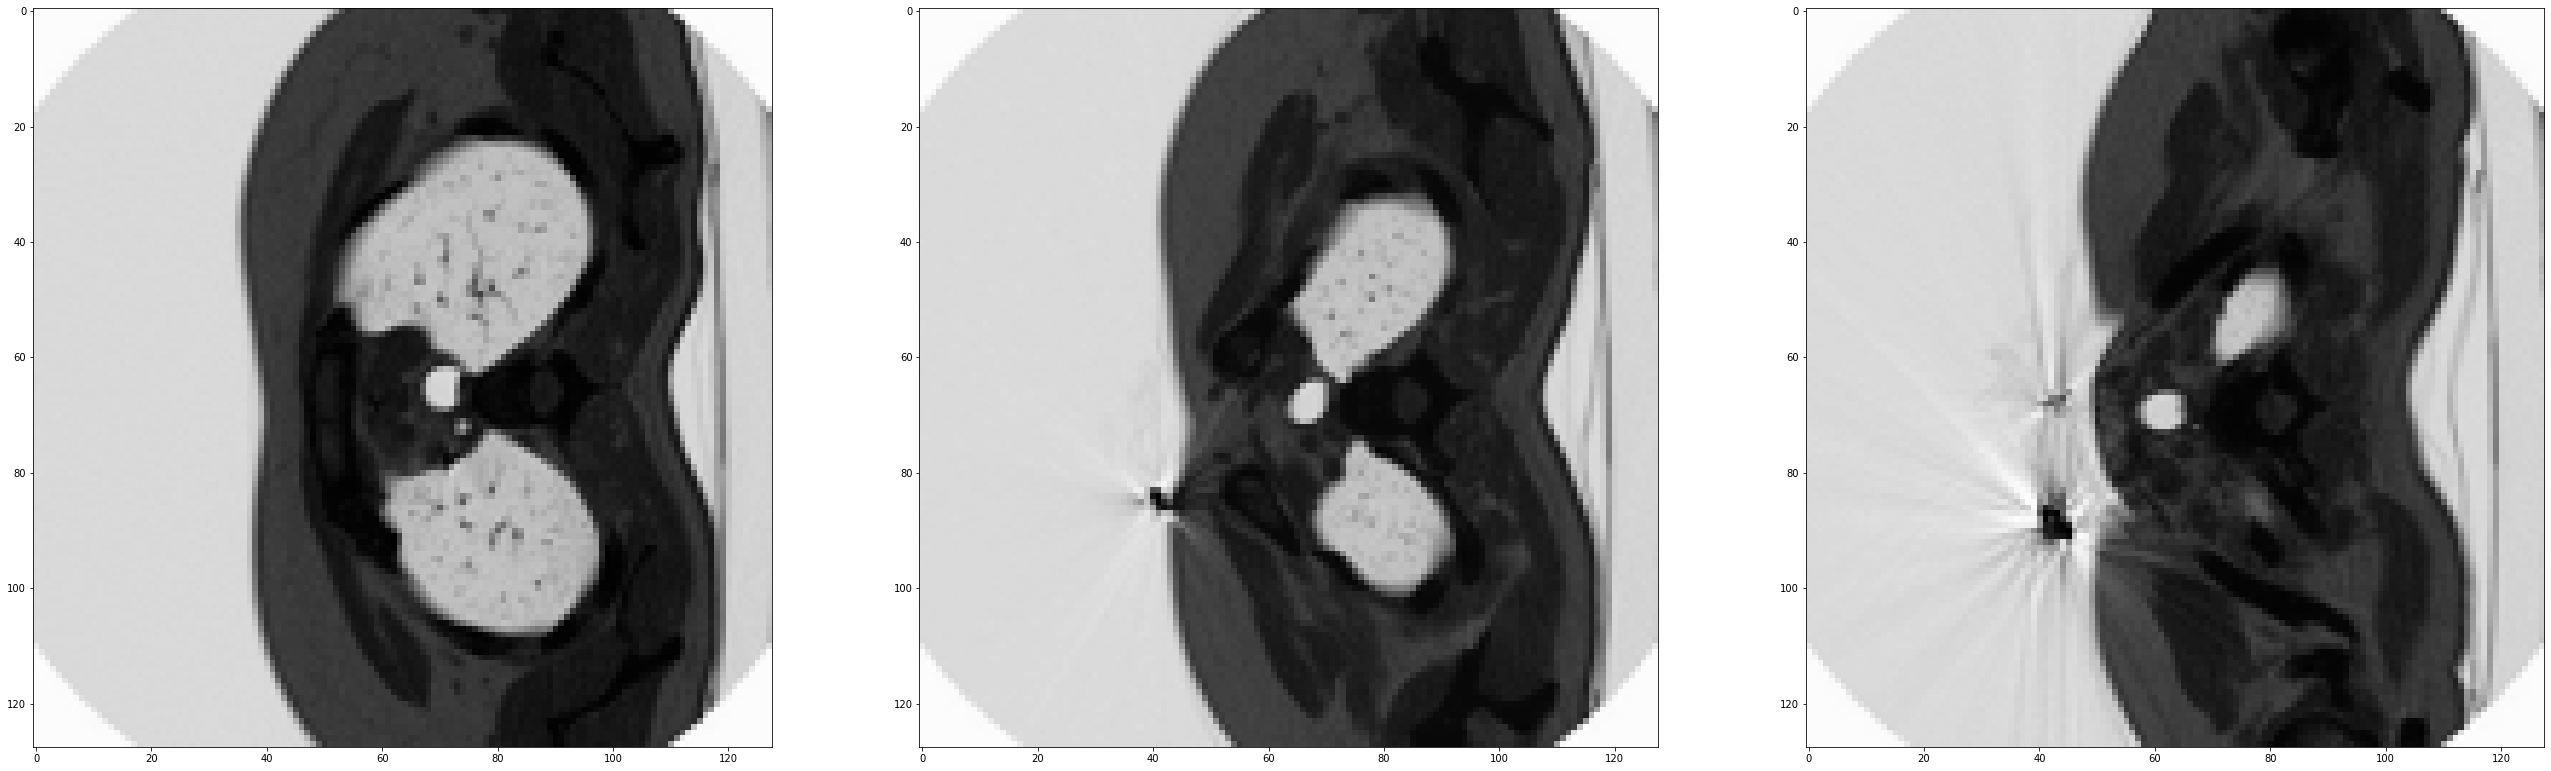

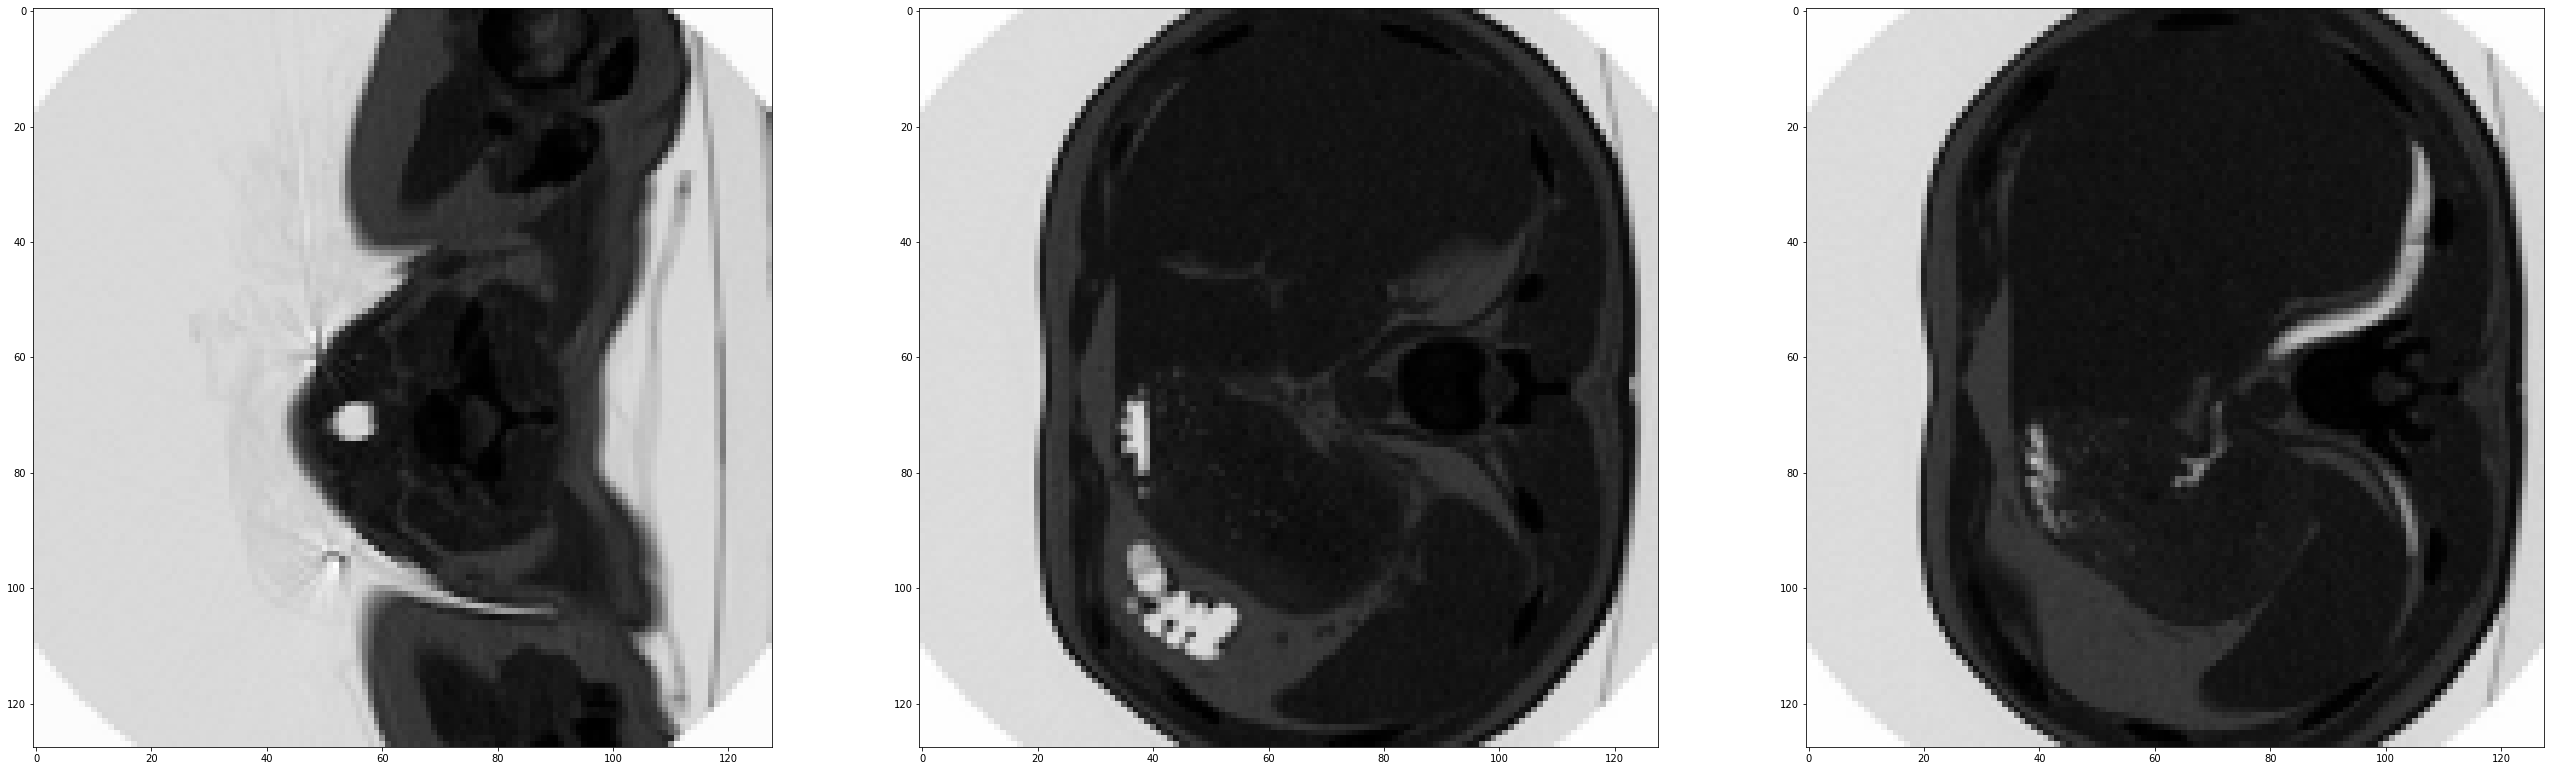

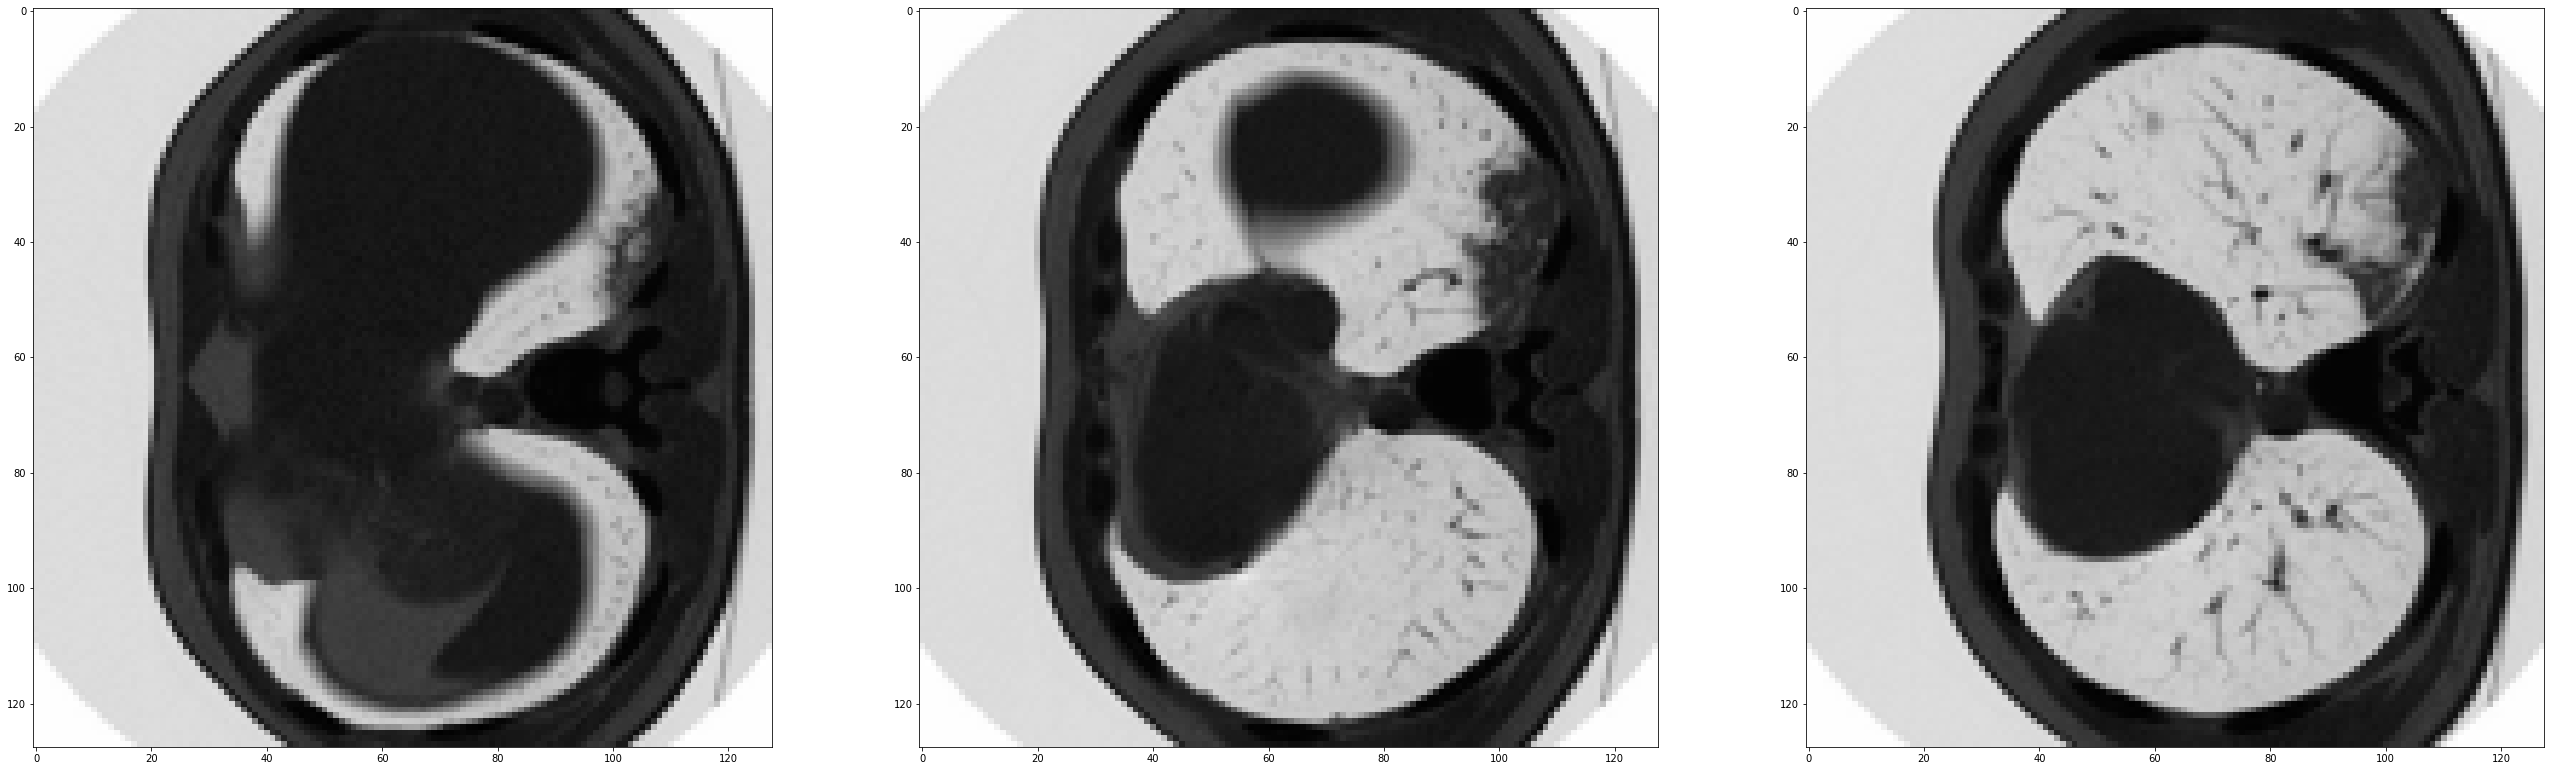

In [20]:
for i in range(780, 800, 9):
    show_im_row(im_radio[i:i+9:3])

Можем видеть, что тут присутствуют срезы одного и того же снимка. С ними нужно действовать аккуратно, чтобы не было переобучения. Возможно, стоит передавать информацию о том, что это срезы одних и тех же легких.

In [21]:
mk_radio_big = np.load('raw-data-kaggle/masks_radiopedia.npy')

In [22]:
mk_radio = np.zeros((4, 829, 128, 128))
for i in range(4):
    mk_radio[i] = resize_dataset(mk_radio_big[:, :, :, i])
    
del mk_radio_big

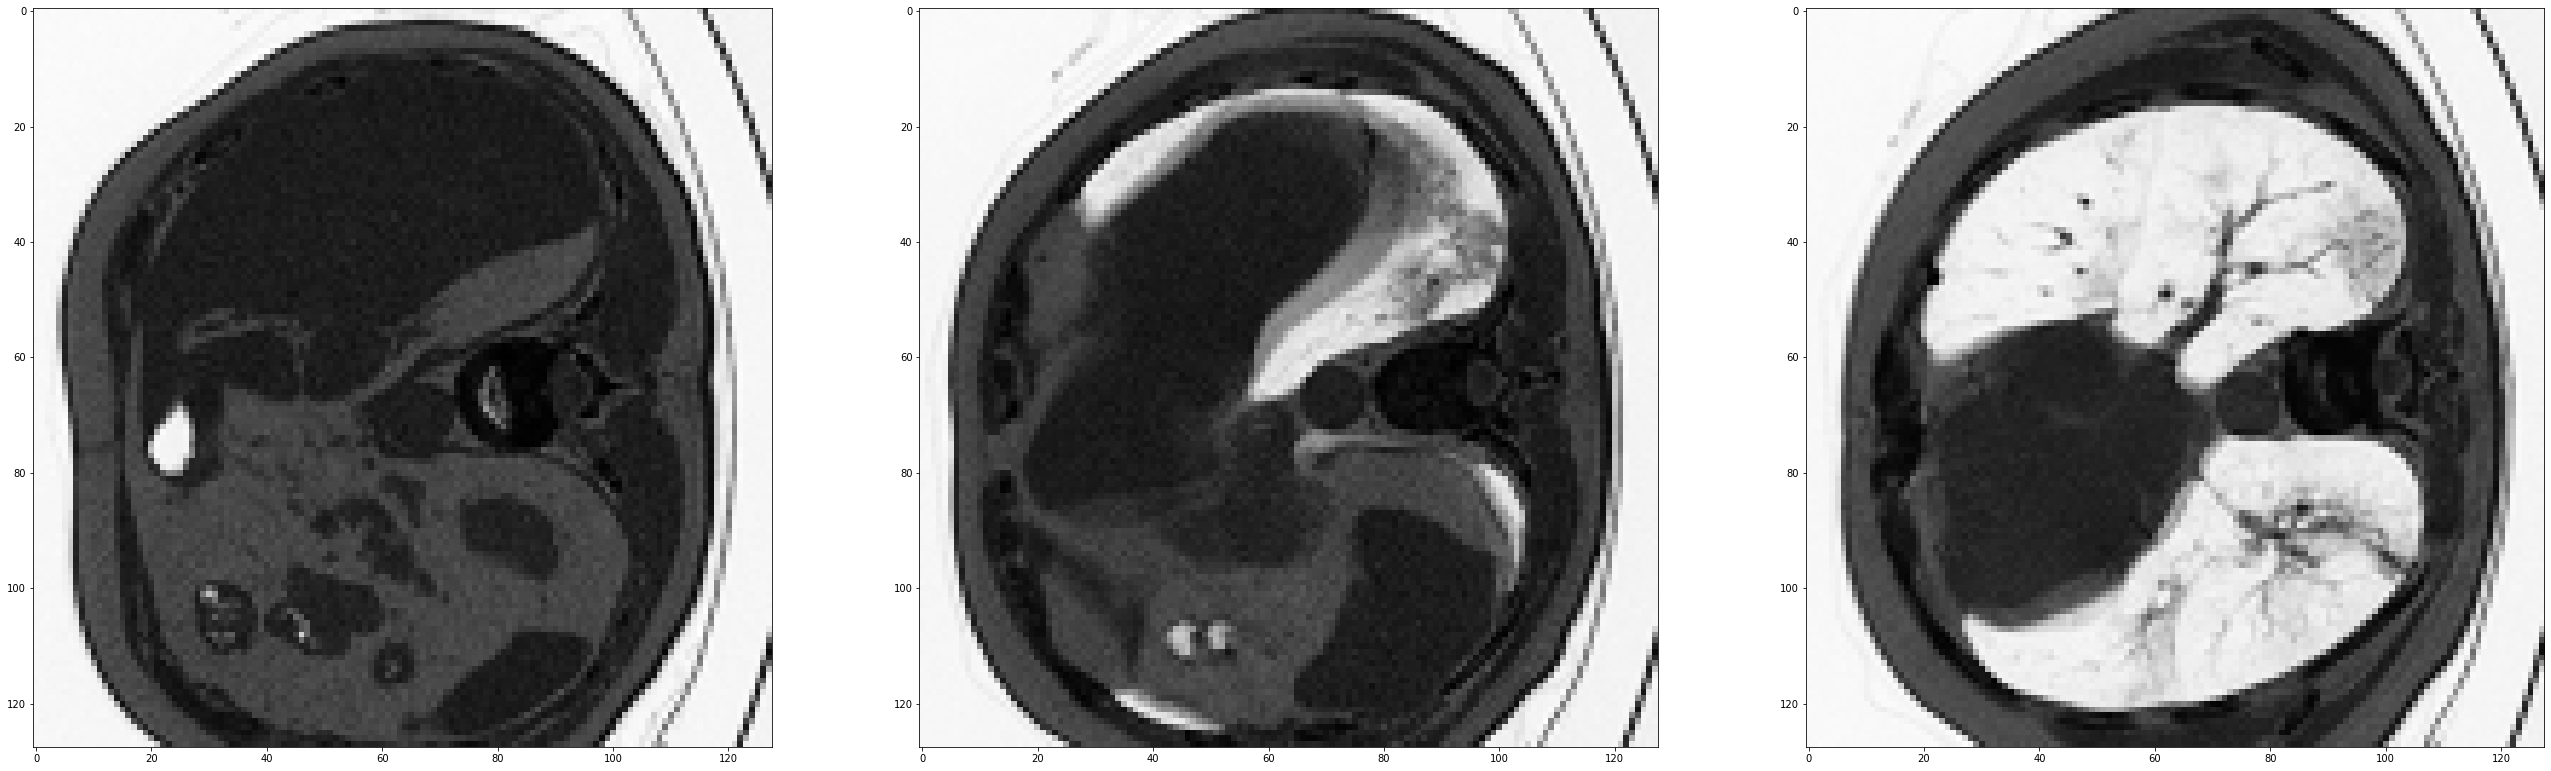

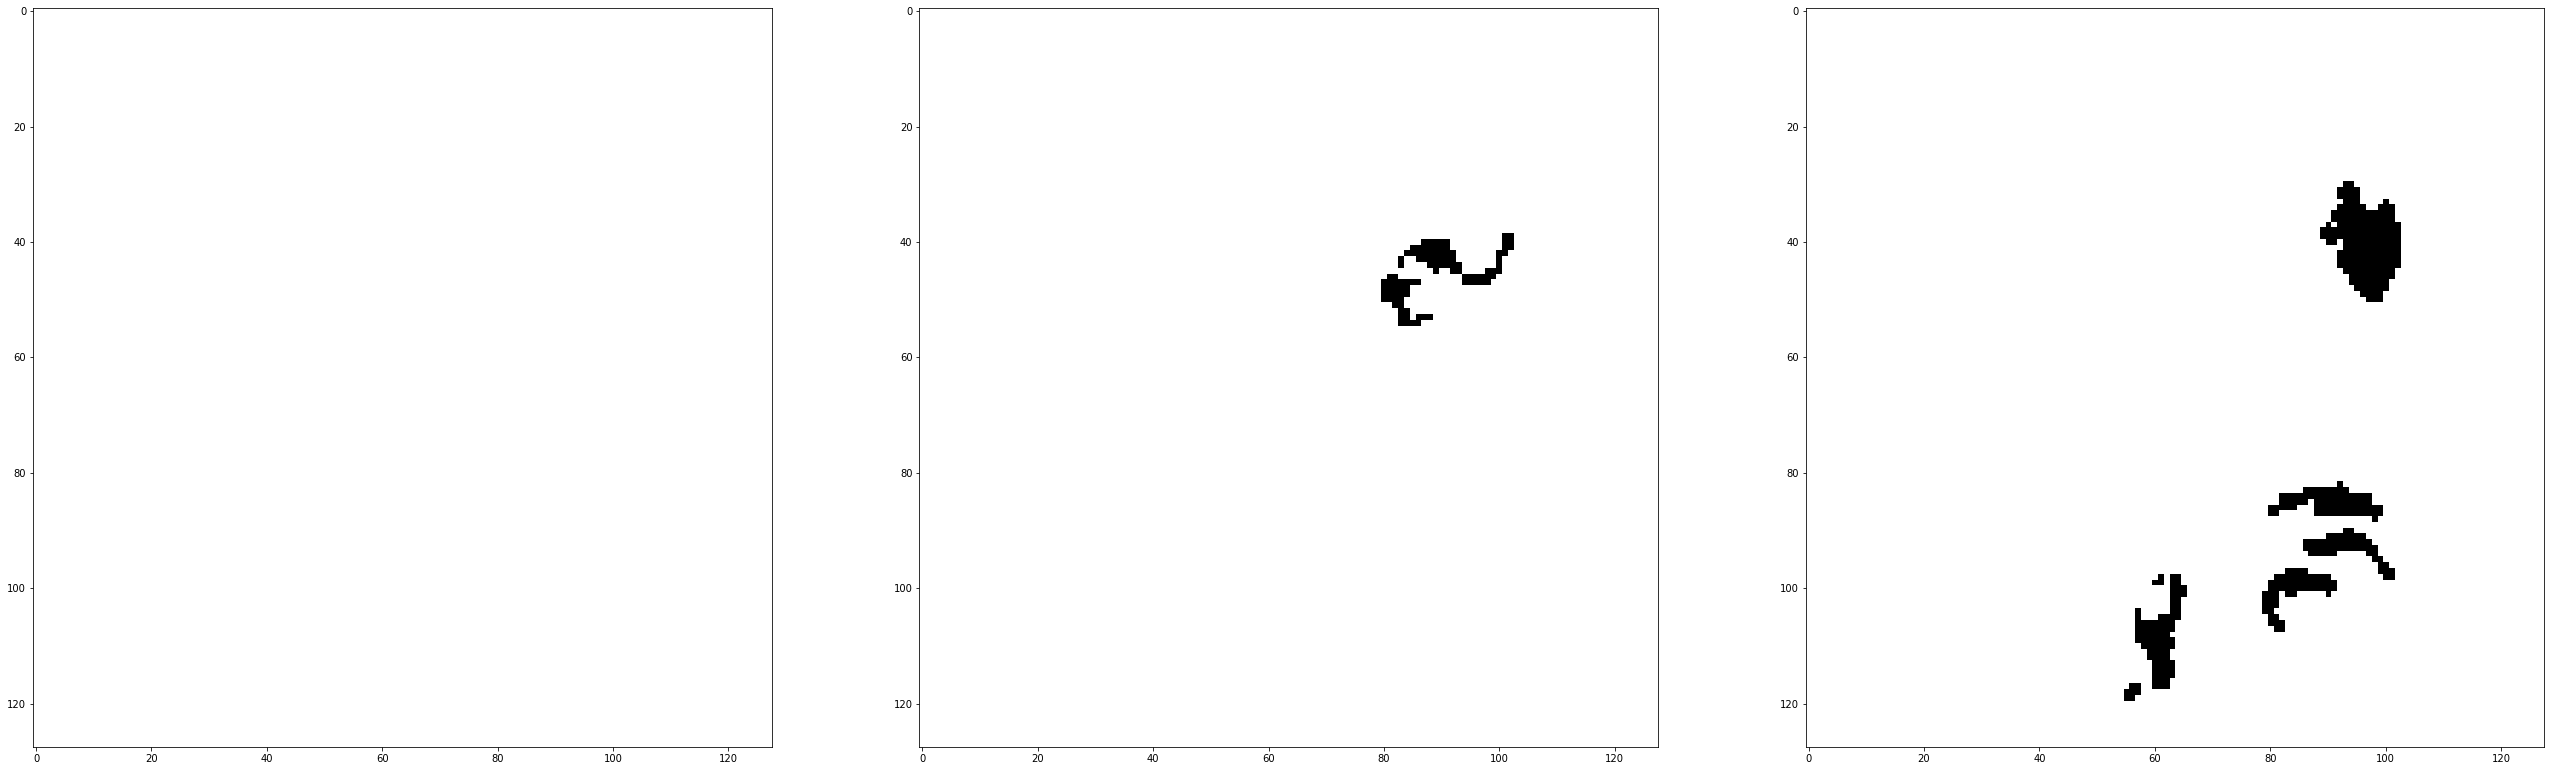

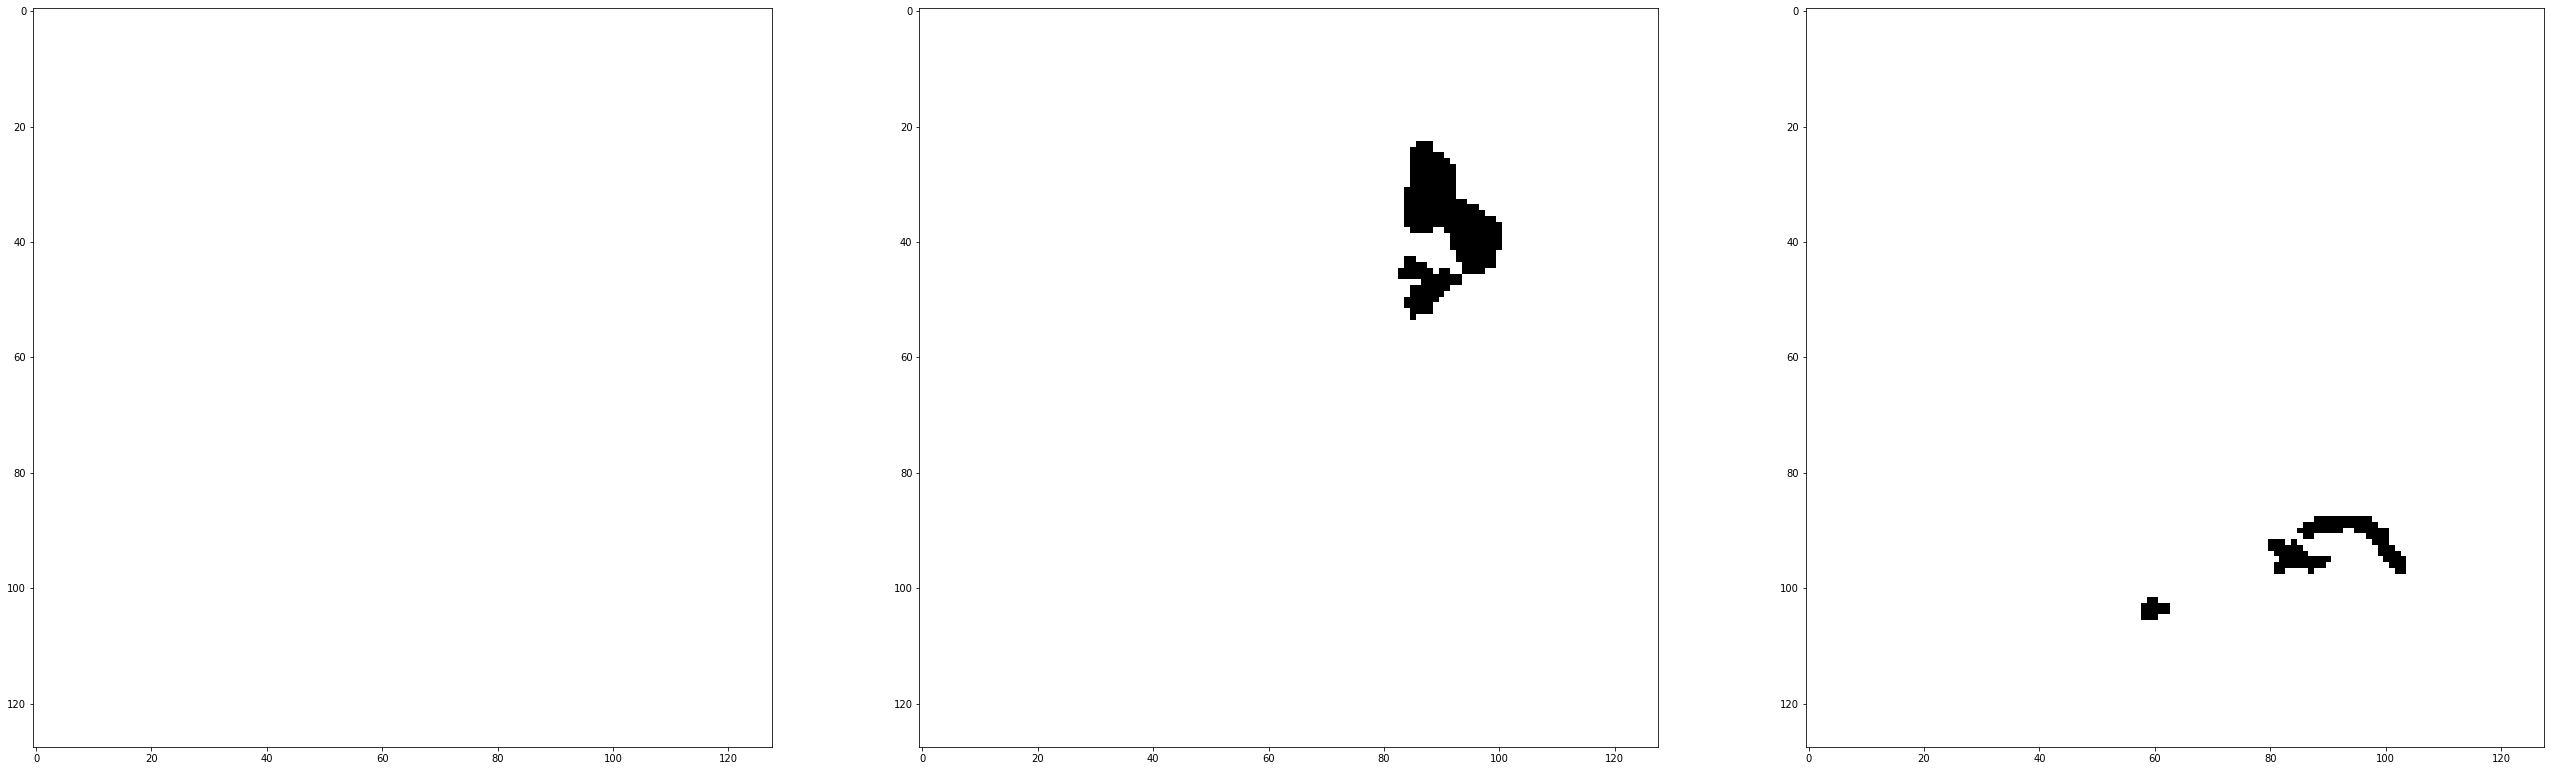

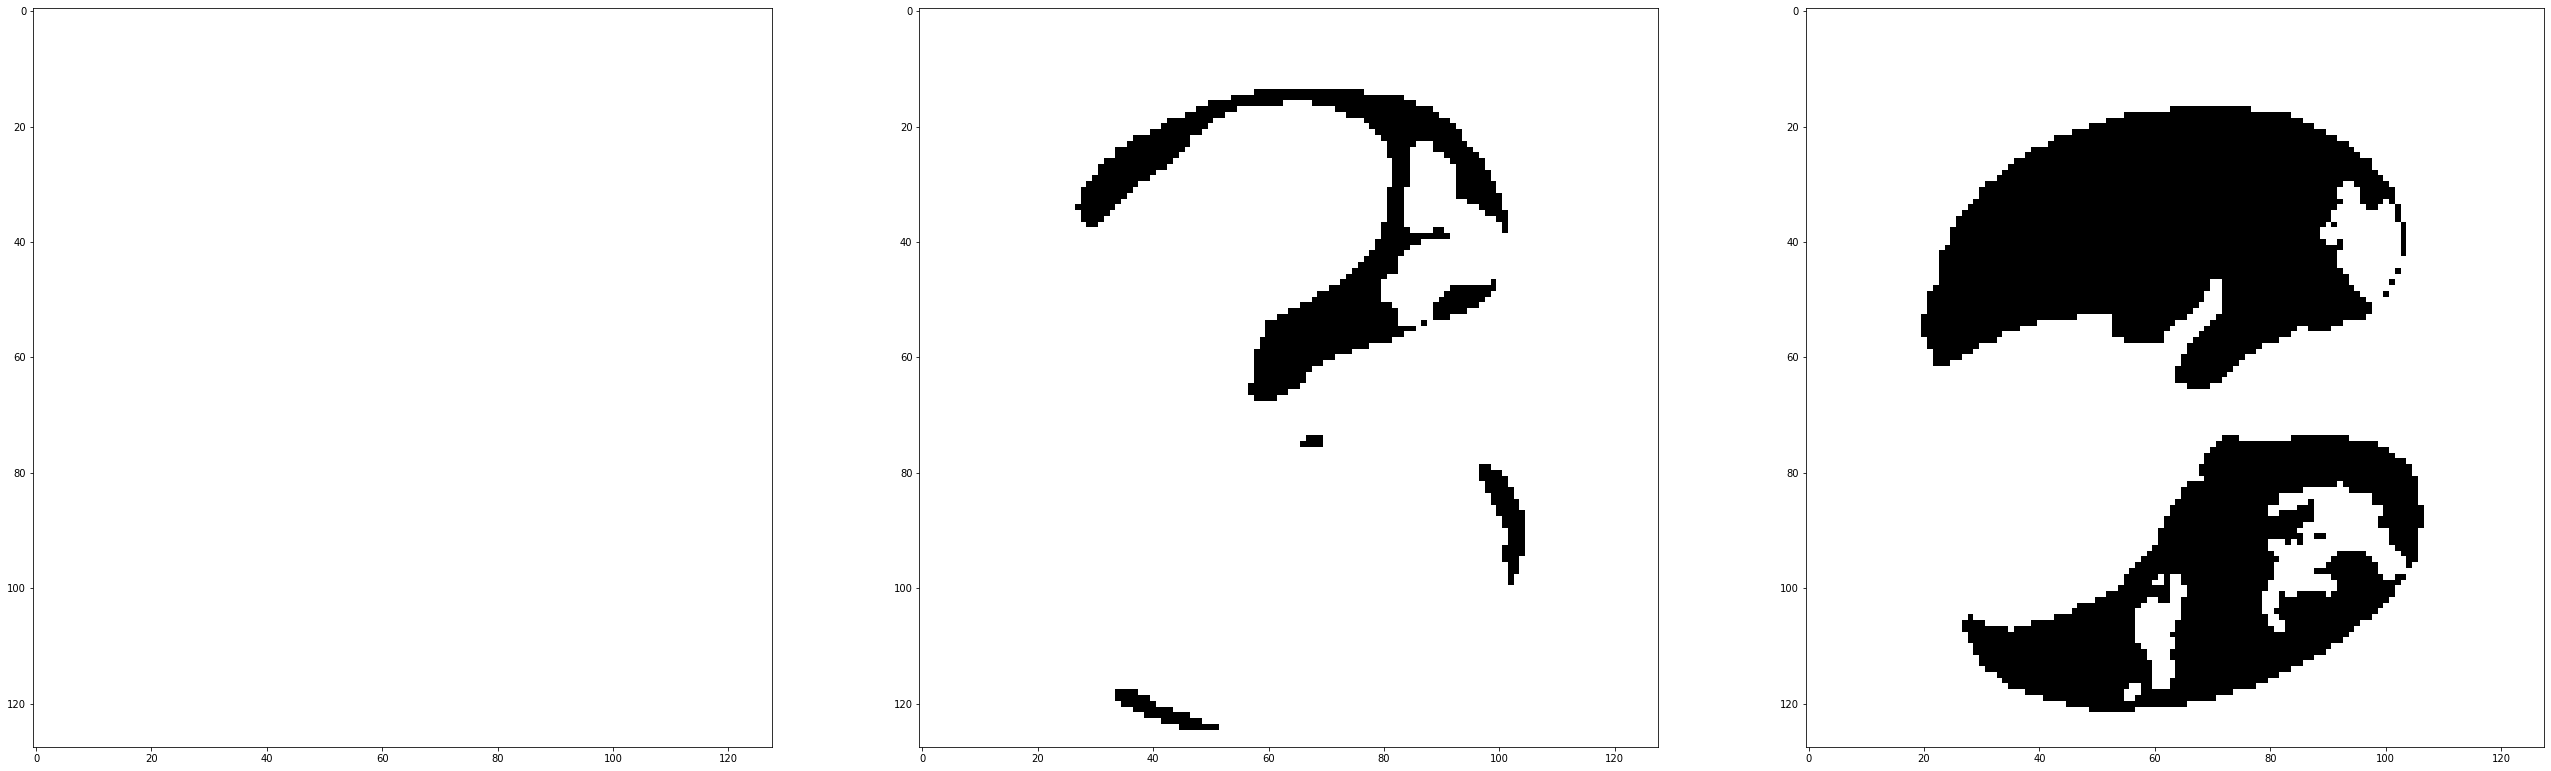

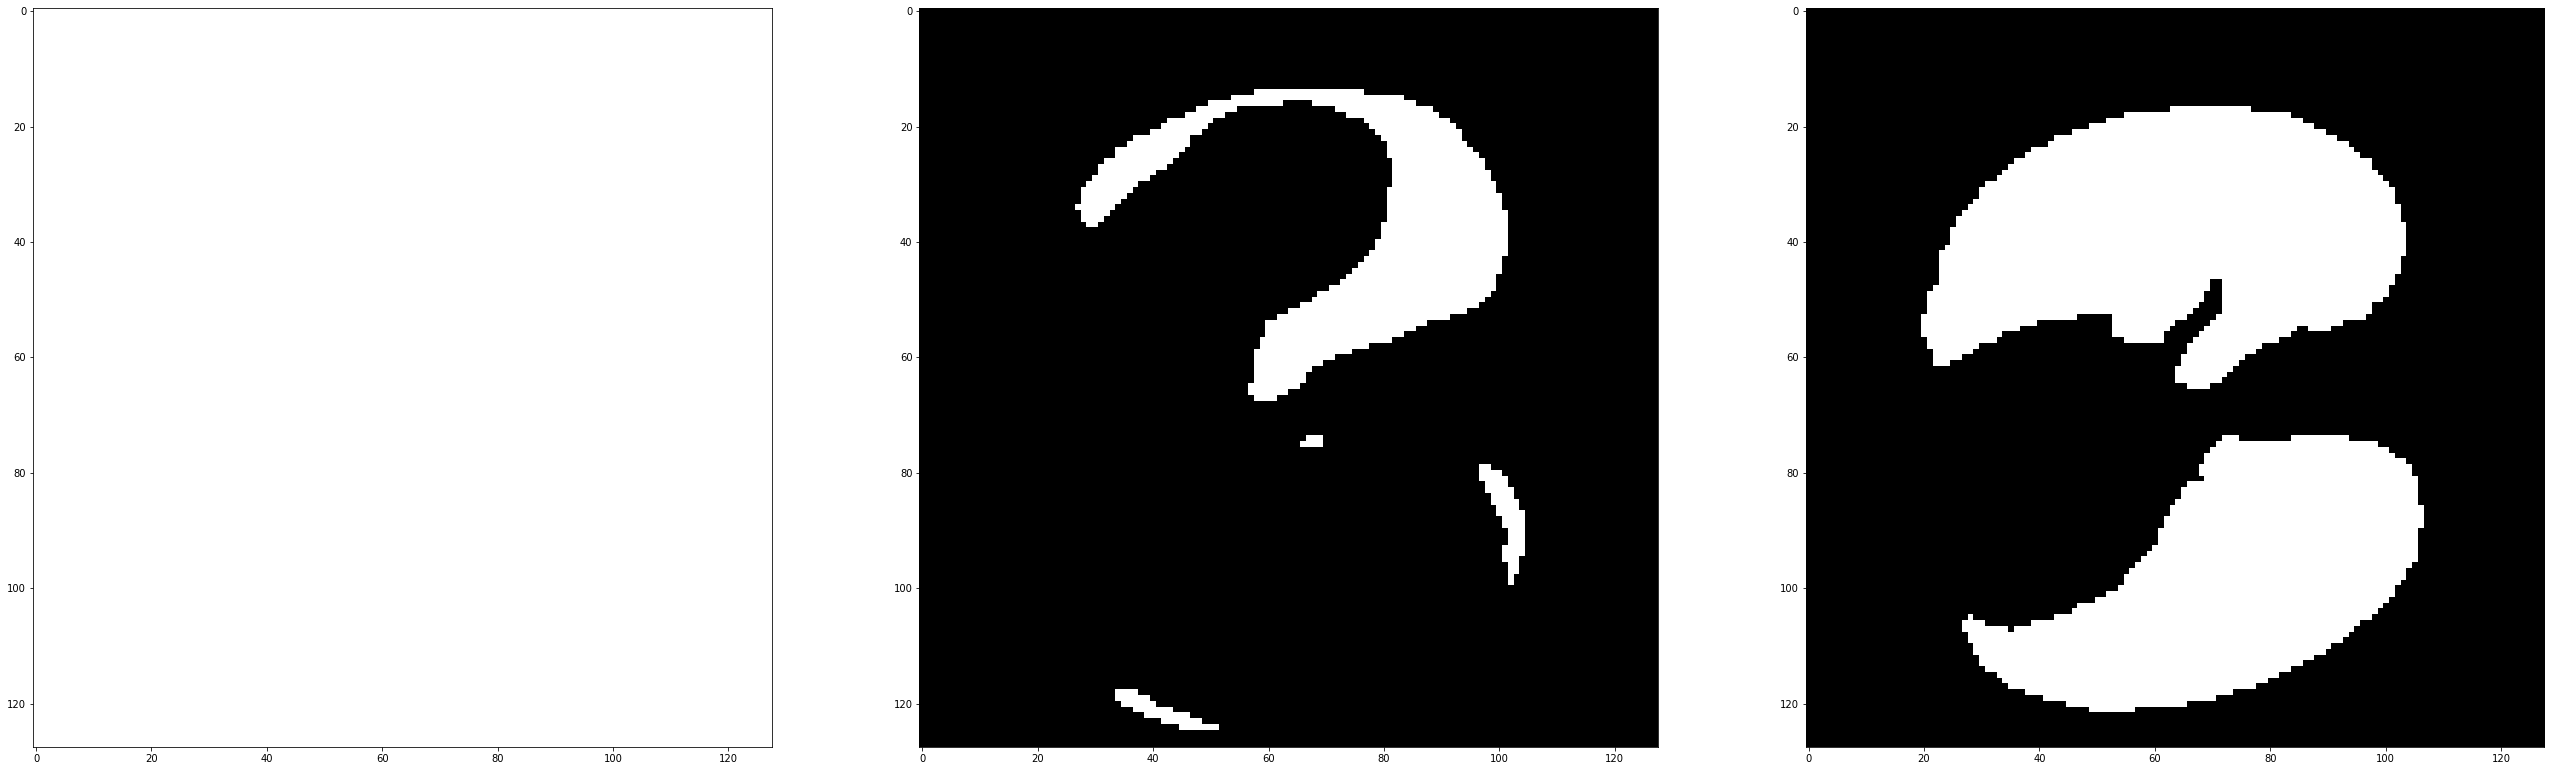

In [23]:
show_im_row(im_radio[3:30:9])
for i in range(4):
    show_im_row(mk_radio[i, 3:30:9])

Видим, что некоторые срезы полностью белые. Вообще говоря, это небольшая неточность прорисовки, и на самом деле некоторые срезы полностью являются фоном:

In [24]:
mk_radio[3, 0]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

Что немного странно. Возможно, это ошибка в разметке данных, и стоит удалить подобные семплы.